## metaphlan2 结果
achen@2020-11-22

In [1]:
import pandas as pd
import os
import glob
from Bio import Seq
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
import re
from scipy.stats import wilcoxon,mannwhitneyu
import numpy as np

In [14]:
abun_dict = {}
for f in glob.glob('../metaphlan2/res/*.result.txt'):
    name = os.path.basename(f).replace('.result.txt','')
    c = 0
    with open(f,'r') as inpf:
        for line in inpf:
            line = line.strip()
            if line[0] == '#':
                continue
            tail = line.split('\t')[0].split('|')[-1]
            num = float(line.split('\t')[1])
            if not tail.startswith('s__'):
                continue
            species = tail.replace('s__','')
            if species not in abun_dict:
                abun_dict[species] = {}
            abun_dict[species][name] = num

In [45]:
abuns = []
res = []
for genome in abun_dict:
    l = []
    h = []
    for smp,abun in abun_dict[genome].items():
        if smp.startswith('H'):
            h.append(abun)
        else:
            l.append(abun)
        abuns.append([genome,smp,abun])
    if len(h)*len(l) == 0:
        continue
    t,p = mannwhitneyu(l,h)
    res.append([genome,len(l),len(h),p])
abuns_df = pd.DataFrame(abuns,columns = ['genome','smp','abun'])
abuns_df['type'] = abuns_df['smp'].str[0]
res_df = pd.DataFrame(res,columns = ['genome','len of l','len of h','pvalue'])
res_df['related smps'] = res_df['len of l'] + res_df['len of h']
res_df = res_df.sort_values(by='related smps',ascending=False)

In [46]:
res_df.head()

,genome,len of l,len of h,pvalue,related smps
0,Bacteroides_vulgatus,123,114,0.004808,237
60,Faecalibacterium_prausnitzii,123,114,0.000571,237
15,Bacteroides_thetaiotaomicron,122,114,0.355988,236
7,Bacteroides_ovatus,122,114,0.143727,236
22,Ruminococcus_torques,123,113,0.224878,236


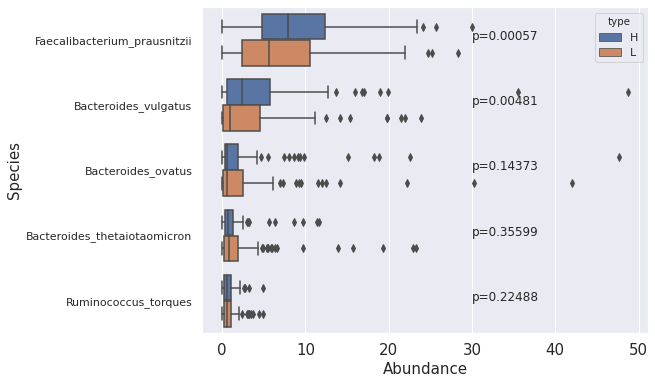

In [146]:
tmpdf = abuns_df[abuns_df.genome.isin(list(res_df.head(n=5).genome))]
sp_order = tmpdf.groupby('genome').agg({'abun':np.mean}).sort_values(by='abun',ascending=False).index.to_list()
#sns.set()
plt.figure(figsize=(8,6))
g = sns.boxplot(data=tmpdf,x='abun',y='genome',hue='type',order=sp_order)
plt.ylabel('Species',fontsize=15)
plt.xlabel('Abundance',fontsize=15)
plt.xticks(fontsize=15)

y_labels = [x.get_text() for x in g.get_yticklabels()]
y_poses = [x.get_position()[1] for x in g.get_yticklabels()]
ps = list(res_df.set_index('genome').loc[y_labels]['pvalue'])
for i in range(len(y_labels)):
    plt.text(30,y_poses[i],f'p={round(ps[i],5)}')

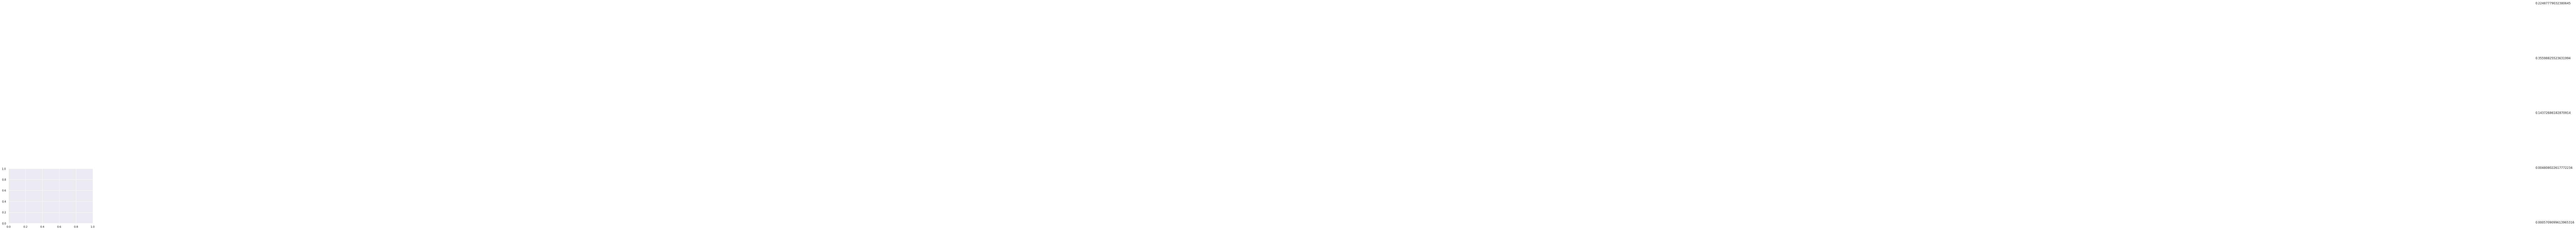

genome
Faecalibacterium_prausnitzii    0.000571
Bacteroides_vulgatus            0.004808
Bacteroides_ovatus              0.143727
Bacteroides_thetaiotaomicron    0.355988
Ruminococcus_torques            0.224878
Name: pvalue, dtype: float64

In [66]:
res_df[res_df['genome'].str.startswith('Faeca')]

,genome,len of l,len of h,pvalue,related smps
60,Faecalibacterium_prausnitzii,123,114,0.000571,237


Text(0.5, 1.0, 'all samples, p=0.0005709099613965316')

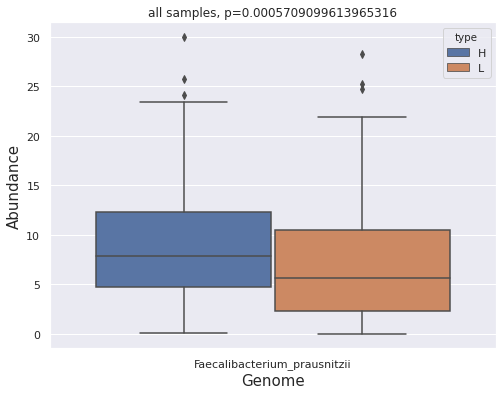

In [104]:
plt.figure(figsize=(8,6))
tmpdf = abuns_df[abuns_df.genome.isin(list(res_df.head(n=5).genome))]
pltdf = tmpdf[tmpdf.genome.str.startswith('Faecalibacterium_prausnitzii')]
sns.boxplot(data=pltdf,x='genome',y='abun',hue='type')
h = pltdf[pltdf['type']=='H']['abun']
l = pltdf[pltdf['type']=='L']['abun']
t,p = mannwhitneyu(h,l)
plt.xlabel('Genome',fontsize=15)
plt.ylabel('Abundance',fontsize=15)
plt.title(f'all samples, p={p}')

In [87]:
len(pltdf)

237

Text(0.5, 1.0, 'valid samples, p=0.012785107109092288')

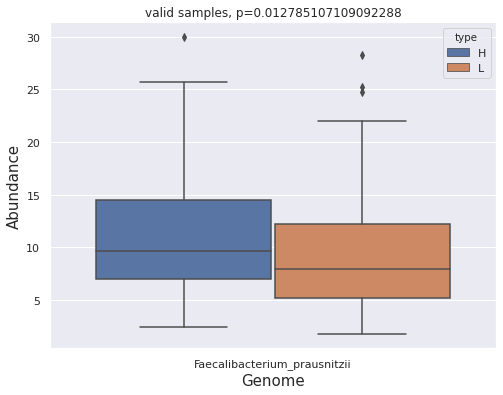

In [105]:
#所以这个结果并不是很好
plt.figure(figsize=(8,6))
tmpdf = abuns_df[abuns_df.genome.isin(list(res_df.head(n=5).genome))]
pltdf = tmpdf[(tmpdf.genome.str.startswith('Faecalibacterium_prausnitzii')) & (tmpdf.smp.isin(valid_smps4fae))]
valid_smps4fae = []
with open('/data1/chenyaowen/workspace/metaSNP_finalversion/liupu/step7_filterSpecies/datalist/GCA_000166035.1.data.list','r') as inpf:
    for line in inpf:
        line = line.strip()
        smp,status = line.split("\t")
        valid_smps4fae.append(smp)
sns.boxplot(data=pltdf,x='genome',y='abun',hue='type')
#sns.swarmplot(data=tmpdf[(tmpdf.genome.str.startswith('Faecalibacterium_prausnitzii')) & (tmpdf.smp.isin(valid_smps4fae))],x='genome',y='abun',hue='type')
h = pltdf[pltdf['type']=='H']['abun']
l = pltdf[pltdf['type']=='L']['abun']
t,p = mannwhitneyu(h,l)
plt.xlabel('Genome',fontsize=15)
plt.ylabel('Abundance',fontsize=15)
plt.title(f'valid samples, p={p}')

In [90]:
len(pltdf)

172